# General Tech Versions/Info
- **Python:** 3.7.10
- **Qiskit**: {'qiskit': '0.24.0',
 'qiskit-aer': '0.7.6',
 'qiskit-aqua': '0.8.2',
 'qiskit-ibmq-provider': '0.12.1',
 'qiskit-ignis': '0.5.2',
 'qiskit-terra': '0.16.4'}
- Run on Google Colab
- Requires 20 qubits + 6 bits

In [1]:
from qiskit import (
    IBMQ,
    QuantumCircuit,
    execute,
    Aer,
    QuantumRegister, 
    ClassicalRegister
)

from qiskit.providers.aer import AerSimulator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_histogram

import numpy as np
import itertools
import math
import random
import csv
import time
import pandas as pd
from qiskit.test.mock import FakeSydney
from qiskit import transpile

In [2]:
syd_unpermuted_layout = [21,18,23,24,17,15,22,11,8,14,13,9,5,16]
syd_syndrome_layout = [10,25,26,3,12,19]

#User Defined Values

In [3]:
NUM_SHOTS = 1
NUM_DIFF_PROGRAMS = 1
NUM_ITERATIONS = 1
NUM_RANDOM_ITERATIONS = 1

In [4]:
# comment out these next two lines if not saving to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# PLEASE CHANGE THESE VALUES ACCORDINGLY: 
filename_0 = "/content/drive/My Drive/Results/general_info_20Q.txt"
filename_error = "/content/drive/My Drive/Results/error_results_20Q.csv"
filename_decoded = "/content/drive/My Drive/Results/decoded_results_20Q.csv"

# SET APPROPRIATE BACKEND
fake_syd = FakeSydney()
BACKEND = AerSimulator.from_backend(fake_syd)

unpermuted_layout = syd_unpermuted_layout
syndrome_layout = syd_syndrome_layout

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Main Functions

In [5]:
class Server():
  def __init__(self):
    print('Server initialized')

  def generate_point(self, size=14):
    # permutation key
    key1 = self.generate_permutation_key()
    # OTP key
    x_key = np.random.randint(2, size=size)
    z_key = np.random.randint(2, size=size)
    key2 = [x_key.tolist(), z_key.tolist()]
    # add all keys to get point
    a = ''.join(key1)
    b = ''.join(map(str, x_key.tolist()))
    c = ''.join(map(str,z_key.tolist()))
    point = a+b+c

    key1 = [int(x,2) for x in key1]
    return point, key1, key2
  
  def generate_permutation_key(self, size=14):
    dec_key = list(range(size))
    rng = np.random.default_rng()
    rng.shuffle(dec_key)
    f = '0' + str(math.ceil(math.log2(size))) + 'b'
    key1 = [format(x, f) for x in dec_key]
    return key1

  def sample_challenge_point(self, point, size=14): #make distribution half and half
    key1 = self.generate_permutation_key()
    key1 = "".join(key1)
    # print(dec_key)
    # print(key1)
    key2_dec = random.randint(0, (2**(size*2))-1)
    key2_bin = format(key2_dec,'0'+str(size*2)+'b')

    random_point = str(key1) + str(key2_bin)
    while random_point == point:
      key2_dec = random.randint(0, (2**(size*2))-1)
      key2_bin = format(key2_dec,'0'+str(size*2)+'b')
      random_point = str(key1) + str(key2_bin)
    # print(key2_bin)
    sample = np.random.choice([random_point, point])
    return sample

In [6]:
def protect(permuted_gates, hg, x_key, z_key, init_data = [0]*14, size=14):
  qr = QuantumRegister(size)
  circuit = QuantumCircuit(qr)
  for i in range(size):
    if x_key[i] == 1 and init_data[i] == 0:
      circuit.x(i)
    if init_data[i] == '+':
      circuit.h(i)
    
  for i in hg:
    circuit.h(i)
  
  for cnots in permuted_gates:
    circuit.cx(cnots[0], cnots[1])
  circuit.barrier()
  return circuit

def get_syndrome_circuit(challenge_input, program, size=14):

  key1, key2 = point_to_keys(challenge_input) 

  qr = QuantumRegister(size)
  sr = QuantumRegister(6)
  cr = ClassicalRegister(6)
  qc = QuantumCircuit(qr,sr, cr)
  qc.append(program, range(size))

  for i in range(14,20):
    qc.h(i)

  syndrome_cnots =[[0, 14], [2, 14], [4, 14], [6, 14], [1, 15], [2, 15], [5, 15], [6, 15], [3, 16], [4, 16], [5, 16], [6, 16], [7, 17], [9, 17], [11, 17], [13, 17], [8, 18], [9, 18], [12, 18], [13, 18], [10, 19], [11, 19], [12, 19], [13, 19]]

  for gate in syndrome_cnots:
    qc.cx(gate[1], key1.index(gate[0]))

  for i in range(14,20):
    qc.h(i)

  qc.barrier()
  qc.measure(sr,cr)
  return qc


def point_to_keys(point, size=14):
  inc = math.ceil(math.log2(size))
  key1 = [int(point[i:i+inc],2) for i in range(0, len(point[:-size*2]), inc)] 
  key2_x = [int(value) for value in point[-size*2:-size]]
  key2_z = [int(value) for value in point[-size:]]
  # key2 = [key2_x, key2_z]
  return key1, [key2_x, key2_z]


def permute_classical(key1, orig_cnot_gates, hadamard_gates = [1,2,3,8,9,10],size=14):
  new_hadamard_gates = [0]*len(hadamard_gates)
  new_cnot_gates = [0]*len(orig_cnot_gates)

  for i in range(len(orig_cnot_gates)):
    new_cnot_gates[i] = [key1.index(orig_cnot_gates[i][0]), key1.index(orig_cnot_gates[i][1])]
  for i in range(len(hadamard_gates)):
    new_hadamard_gates[i] = key1.index(hadamard_gates[i])

  return new_cnot_gates, new_hadamard_gates


def get_OTP_classical_key(key, permutation_key, cnot_gates, hadamard_gates):
  x_key = key[0]
  z_key = key[1]
  # size = 14

  for cnot in cnot_gates:
    a = x_key[cnot[0]]
    b = z_key[cnot[0]]
    c = x_key[cnot[1]]
    d = z_key[cnot[1]]
    x_key[cnot[0]] = a
    z_key[cnot[0]] = b+d
    x_key[cnot[1]] = a+c
    z_key[cnot[1]] = d

  for i in hadamard_gates:
    x_key[i], z_key[i] = z_key[i], x_key[i]

  new_x_key = [i%2 for i in x_key]
  new_z_key = [i%2 for i in z_key]

  return new_x_key, new_z_key


def undo_circuit(point, program, rev_cnot_gates=[[3,6],[3,5],[3,4],[2,6],[2,4],[2,0],[1,5],[1,4],[1,0],[0,6],[0,5],[10, 13],[10, 12],[10, 11],[9, 13],[9, 11],[9, 7],[8, 12],[8, 11],[8, 7],[7, 13],[7, 12]], size=14):

  key1, key2 = point_to_keys(point) 
  print("rev len:", len(rev_cnot_gates))
  permuted_cnots, hg =permute_classical(key1, orig_cnot_gates = rev_cnot_gates)
  qr = QuantumRegister(size)
  cr_trap = ClassicalRegister(size)
  qc = QuantumCircuit(qr, cr_trap)
  qc.append(program, range(size))

  for cnot in permuted_cnots:
    qc.cx(cnot[0], cnot[1])
  
  qc.barrier()
  for gate in hg:
    qc.h(gate)
  qc.barrier()

  qc.measure(qr, cr_trap)
  return qc
  
def reverse_cnots(cnots):
  rev_cnots = []
  for i in range(len(cnots)):
    rev_cnots.append(cnots[len(cnots)-i-1])
  return rev_cnots

# Tests

In [7]:
server = Server()
start = time.time()
fields = ['is_point', 'point_value', 'challenge_point_value', 'key_1', 'key_2', 'challenge_key_1', 'challenge_key_2']

Server initialized


## Measurement Error Mitigation

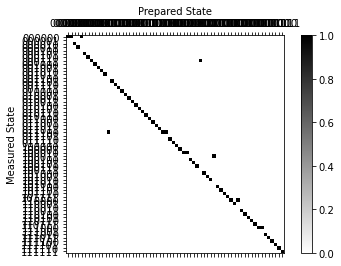

10.048921346664429


In [8]:
s = time.time()
qr = QuantumRegister(6) # quantum circuit with three qubits
qulayout = range(6)
cal_circuits, state_labels = complete_meas_cal(qubit_list=qulayout,qr=qr, circlabel="measure_error_mitigation_cal" )
cal_job = execute(cal_circuits, backend = BACKEND, shots=NUM_SHOTS)

cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
x = time.time() -s
print(x)

## Steane code for |0> and |+> trap code (14 Qubits) 

In [9]:
 CNOT_GATES = [[1,0], [1,4], [1,5], [2,0], [2,4], [2,6], [3,4], [3,5],[3,6],[7, 12],[7, 13],[8,7] ,[8, 11],[8, 12], [9,7],[9, 11],[9, 13],[10, 11],[10, 12],[10, 13]]
 REV_CNOT_GATES = [[10, 13],[10, 12],[10, 11],[9, 13],[9, 11],[9,7],[8, 12],[8, 11],[8,7],[7, 13],[7, 12],[3,6],[3,5],[3,4],[2,6],[2,4],[2,0],[1,5],[1,4],[1,0]]




> ### Test 1.1: Point = Challenge Input Correctness Check

In [10]:
results_info = pd.DataFrame(columns=fields)
results_info_decoded = pd.DataFrame(columns=fields)
sp_list= []
dp_list = []
A_values = []
print("_____________PART A: Challenge Input = Point_____________")
for i in range(NUM_DIFF_PROGRAMS):
  p, k1, k2 = server.generate_point()
  key2 = [k2[0][:], k2[1][:]]
  pg, hg = permute_classical(k1, orig_cnot_gates=CNOT_GATES)
  rev = reverse_cnots(pg)
  x_key, z_key = get_OTP_classical_key(k2,k1, rev,hg)
  data = [0]*14
  data[k1.index(7)] = '+'
  program = protect(pg, hg, x_key, z_key, init_data=data)
  challenge_input = p
  challenge_key1, challenge_key2 = point_to_keys(challenge_input)  
  A_values.append([p,k1,k2,challenge_input, challenge_key1, challenge_key2])  
  for k in range(NUM_ITERATIONS): 
    syndrome_program = get_syndrome_circuit(p,program)
    decoded_program = undo_circuit(challenge_input, program, rev_cnot_gates=REV_CNOT_GATES)
    sp_list = sp_list + [syndrome_program]
    dp_list = dp_list + [decoded_program]
    index = i*NUM_ITERATIONS+k
    results_info.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
    results_info_decoded.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]


_____________PART A: Challenge Input = Point_____________
rev len: 20




> ### Test 1.2: Point != Challenge Input, w/ 1 permutation error Correctness Check




In [11]:
B_values = []
print("\n_____________PART B: Challenge Input != Point - one Permutation Error_____________")
for j in range(NUM_DIFF_PROGRAMS):
  p, k1, k2 = server.generate_point()
  key2 = [k2[0][:], k2[1][:]]
  print("k1", k1)
  i = np.random.choice(14,2,False)
  edited_k1 = k1[:]
  edited_k1[i[0]], edited_k1[i[1]] = k1[i[1]], k1[i[0]]
  f = '0' + str(math.ceil(math.log2(14))) + 'b'
  new_key1 = [format(x, f) for x in edited_k1]
  challenge_input = str("".join(new_key1)) + str(p[-28:])
  challenge_key1, challenge_key2 = point_to_keys(challenge_input)
  B_values.append([p,k1,k2,challenge_input,challenge_key1, challenge_key2])  

  pg, hg = permute_classical(k1, orig_cnot_gates=CNOT_GATES)
  rev = reverse_cnots(pg)
  x_key, z_key = get_OTP_classical_key(k2,k1, rev,hg)
  data = [0]*14
  data[k1.index(7)] = '+'
  program = protect(pg, hg, x_key, z_key, init_data=data)
  for k in range(NUM_ITERATIONS): 
    syndrome_program = get_syndrome_circuit(p,program)
    decoded_program = undo_circuit(challenge_input, program, rev_cnot_gates=REV_CNOT_GATES)
    sp_list = sp_list + [syndrome_program]
    dp_list = dp_list + [decoded_program]
    index = j*NUM_ITERATIONS+k +(NUM_ITERATIONS*NUM_DIFF_PROGRAMS)
    results_info_decoded.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
    results_info.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
print(len(results_info))



_____________PART B: Challenge Input != Point - one Permutation Error_____________
k1 [9, 6, 10, 8, 2, 4, 0, 1, 13, 7, 11, 12, 3, 5]
rev len: 20
2




> ### Test 1.3: Point != Challenge Input, w/ 1 X error Correctness Check


In [12]:
C_values = []
print("\n_____________PART C: Challenge Input != Point - one X Error_____________")
for j in range(NUM_DIFF_PROGRAMS):
  p, k1, k2 = server.generate_point()
  key2 = [k2[0][:], k2[1][:]]
  i = np.random.choice(6,1,False)
  index = (i[0]-14)
  challenge_input = str(p[:index]) + str((int(p[index])+1)%2) + str(p[index+1:])
  challenge_key1, challenge_key2 = point_to_keys(challenge_input)
  pg, hg = permute_classical(k1, orig_cnot_gates=CNOT_GATES) 
  rev = reverse_cnots(pg)
  x_key, z_key = get_OTP_classical_key(k2,k1, rev,hg)
  data = [0]*14
  data[k1.index(7)] = '+'
  program = protect(pg, hg, x_key, z_key, init_data=data)
  C_values.append([p,k1,k2,challenge_input,challenge_key1, challenge_key2])  
   
  for k in range(NUM_ITERATIONS): 
    syndrome_program = get_syndrome_circuit(p,program)
    decoded_program = undo_circuit(challenge_input, program, rev_cnot_gates=REV_CNOT_GATES)
    sp_list = sp_list + [syndrome_program]
    dp_list = dp_list + [decoded_program]
    index = j*NUM_ITERATIONS+k +(NUM_ITERATIONS*NUM_DIFF_PROGRAMS*2)
    results_info_decoded.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
    results_info.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
print(len(results_info))


_____________PART C: Challenge Input != Point - one X Error_____________
rev len: 20
3



> ### Test 1.4: Point != Challenge Input, w/ 1 Z error Correctness Check





In [13]:
D_values = []
print("\n_____________PART D: Challenge Input != Point - one Z-Error_____________")
for j in range(NUM_DIFF_PROGRAMS ):
  p, k1, k2 = server.generate_point()
  key2 = [k2[0][:], k2[1][:]]
  i = np.random.choice(5,1,False)
  index = (i[0]-7)
  challenge_input = str(p[:index]) + str((int(p[index])+1)%2) + str(p[index+1:])
  challenge_key1, challenge_key2 = point_to_keys(challenge_input)
  pg, hg = permute_classical(k1, orig_cnot_gates=CNOT_GATES)
  rev = reverse_cnots(pg)
  x_key, z_key = get_OTP_classical_key(k2,k1, rev,hg)
  data = [0]*14
  data[k1.index(7)] = '+'
  program = protect(pg, hg, x_key, z_key, init_data=data)
  D_values.append([p,k1,k2,challenge_input,challenge_key1, challenge_key2])  

  for k in range(NUM_ITERATIONS): 
    syndrome_program = get_syndrome_circuit(p,program)
    decoded_program = undo_circuit(challenge_input, program, rev_cnot_gates=REV_CNOT_GATES)
    sp_list = sp_list + [syndrome_program]
    dp_list = dp_list + [decoded_program]
    index = j*NUM_ITERATIONS+k +(NUM_ITERATIONS*NUM_DIFF_PROGRAMS*3)
    results_info.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
    results_info_decoded.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]

print(len(results_info))


_____________PART D: Challenge Input != Point - one Z-Error_____________
rev len: 20
4



> ### Test 1.5: Point != Challenge Input, w/ 1 X, Z error EACH





In [14]:
E_values = []
print("\n_____________PART E: Challenge Input != Point - one X and Z Error_____________")
for j in range(NUM_DIFF_PROGRAMS):
  p, k1, k2 = server.generate_point()
  key2 = [k2[0][:], k2[1][:]]

  i = np.sort(np.random.choice(5,2,False))
  x_error_index = i[0] - 14
  z_error_index = i[1] - 7
  challenge_input = str(p[:x_error_index]) + str((int(p[x_error_index])+1)%2) + str(p[x_error_index+1: z_error_index])+ str((int(p[z_error_index])+1)%2)+ str(p[z_error_index+1:])
  challenge_key1, challenge_key2 = point_to_keys(challenge_input)
  pg, hg = permute_classical(k1, orig_cnot_gates=CNOT_GATES)
  rev = reverse_cnots(pg)
  x_key, z_key = get_OTP_classical_key(k2,k1, rev,hg)
  data = [0]*14
  data[k1.index(7)] = '+'
  program = protect(pg, hg, x_key, z_key, init_data=data)
  E_values.append([p,k1,k2,challenge_input,challenge_key1, challenge_key2])  

  for k in range(NUM_ITERATIONS): 
    syndrome_program = get_syndrome_circuit(p,program)
    decoded_program = undo_circuit(challenge_input, program, rev_cnot_gates=REV_CNOT_GATES)
    sp_list = sp_list + [syndrome_program]
    dp_list = dp_list + [decoded_program]
    index = j*NUM_ITERATIONS+k +(NUM_ITERATIONS*NUM_DIFF_PROGRAMS*4)
    results_info.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
    results_info_decoded.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]

print(len(results_info))


_____________PART E: Challenge Input != Point - one X and Z Error_____________
rev len: 20
5




> ### Test 1.6: Point != Challenge Input, w/ 1 random error Correctness Check



In [15]:
F_values = []
print("\n_____________PART F: Random Challenge Input_____________")
for i in range(NUM_RANDOM_ITERATIONS):
  # server = Server()
  p, k1, k2 = server.generate_point()
  key2 = [k2[0][:], k2[1][:]]
  pg, hg = permute_classical(k1, orig_cnot_gates=CNOT_GATES) 
  rev = reverse_cnots(pg)
  x_key, z_key = get_OTP_classical_key(k2,k1, rev,hg)
  data = [0]*14
  data[k1.index(7)] = '+'
  program = protect(pg, hg, x_key, z_key, init_data=data)
  challenge_input = server.sample_challenge_point(p)
  challenge_key1, challenge_key2 = point_to_keys(challenge_input)

  F_values.append([p,k1,k2,challenge_input,challenge_key1, challenge_key2])  

  syndrome_program = get_syndrome_circuit(p,program)
  decoded_program = undo_circuit(challenge_input, program, rev_cnot_gates=REV_CNOT_GATES)
  sp_list = sp_list + [syndrome_program]
  dp_list = dp_list + [decoded_program]
  index = (NUM_ITERATIONS*NUM_DIFF_PROGRAMS*5)+i
  results_info.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]
  results_info_decoded.loc[index] = [str(p) == str(challenge_input), p, challenge_input, k1, key2, challenge_key1, challenge_key2]




_____________PART F: Random Challenge Input_____________
rev len: 20


## EXECUTE CIRCUITS

### Transpile Code

### Apply permutation of circuit to get optimal qubit mapping

In [16]:
init_qubits= []
init_qubits_msg = []
for key1 in results_info.challenge_key_1:
  k1 = key1[:]
  for i in range(len(k1)):
    k1[i]= unpermuted_layout[k1[i]]
  init_qubits_msg.append(k1[:])
  for j in syndrome_layout:
    k1.append(j)
  init_qubits.append(k1)

d = {}
transpiled_sp_list = []
transpiled_sp_depths = []
for i in range(len(sp_list)):
  min_circ = transpile(sp_list[i], BACKEND, initial_layout=init_qubits[i])
  min_depth = min_circ.depth()
  for j in range(1):
    transpiled_circ = transpile(sp_list[i], BACKEND, initial_layout=init_qubits[i],optimization_level=2)
    depth = transpiled_circ.depth()
    if depth < min_depth:
      min_depth = depth
      min_circ = transpiled_circ

    if depth in d:
      d[depth] = d[depth] +1
    else:
      d[depth] = 1
  transpiled_sp_list.append(min_circ)
  transpiled_sp_depths.append(min_circ.depth())
  print(min_depth)

transpiled_sp_msg_list = []
transpiled_sp_msg_depths = []

for i in range(len(dp_list)):
  min_circ = transpile(dp_list[i], BACKEND, initial_layout=init_qubits_msg[i])
  min_depth = min_circ.depth()
  for j in range(1):
    transpiled_circ = transpile(dp_list[i], BACKEND, initial_layout=init_qubits_msg[i],optimization_level=2)
    depth = transpiled_circ.depth()
    if depth < min_depth:
      min_depth = depth
      min_circ = transpiled_circ

    if depth in d:
      d[depth] = d[depth] +1
    else:
      d[depth] = 1
  transpiled_sp_msg_list.append(min_circ)
  transpiled_sp_msg_depths.append(min_circ.depth())

  print(min_depth)



83
86
90
87
90
93
58
78
60
61
61
53


> ### Run Transpiled Circuits on Quantum Computers

In [17]:
job = execute(transpiled_sp_list, BACKEND, shots=NUM_SHOTS)

results_sim = job.result()
counts = results_sim.get_counts()

mit_counts_list = []

for j in range(NUM_ITERATIONS*NUM_DIFF_PROGRAMS*5+ NUM_RANDOM_ITERATIONS):
  mitigated_result = meas_filter.apply(results_sim)
  mitigated_counts = mitigated_result.get_counts(transpiled_sp_list[j])
  mit_counts_list.append(str(mitigated_counts))

results_info.insert(7, "device_counts",counts)
results_info.insert(8, "mitigated_counts",mit_counts_list)
results_info.insert(9, "circuit_depth", transpiled_sp_depths)
results_info.to_csv(filename_error)


In [21]:
job = execute(transpiled_sp_msg_list, BACKEND, shots=NUM_SHOTS)
results_sim = job.result()
counts = results_sim.get_counts()

results_info_decoded.insert(7, "device_counts",counts)
results_info_decoded.insert(8, "circuit_depth", transpiled_sp_msg_depths)
results_info_decoded.to_csv(filename_decoded)

In [22]:
with open(filename_0, 'w') as writefile:
  x = time.time() - start
  writefile.write("--------------------ELAPSED TIME: \n")
  writefile.write(str(x))